#### Installing PySpark

In [16]:
!pip install pyspark

#### Importing Libraries

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import MulticlassMetrics


#### Creating Spark Session

In [18]:
# Create a Spark session
spark = SparkSession.builder.appName("AnimeRatings").getOrCreate()

#### Loading CSV File

In [42]:
# Load the CSV file
df = spark.read.csv("./animes.csv", header=True, inferSchema=True)

df.show()

root
 |-- uid: string (nullable = true)
 |-- title: string (nullable = true)
 |-- synopsis: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- aired: string (nullable = true)
 |-- episodes: string (nullable = true)
 |-- members: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- ranked: string (nullable = true)
 |-- score: string (nullable = true)
 |-- img_url: string (nullable = true)
 |-- link: string (nullable = true)



+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----+
|                 uid|               title|            synopsis|               genre|               aired|            episodes|             members|          popularity|              ranked|               score|img_url|link|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----+
|               28891|Haikyuu!! Second ...|Following their p...|                NULL|                NULL|                NULL|                NULL|                NULL|                NULL|                NULL|   NULL|NULL|
|When they receive...| Karasuno agrees ...| they hope not on...| but also come up...| Hinata and Kag

#### Data Pre-processing

In [20]:
# Remove the columns "link" and "img_url"
df = df.drop("link", "img_url")

# Convert columns to numeric values
df = df.withColumn("episodes", col("episodes").cast("int"))
df = df.withColumn("members", col("members").cast("int"))
df = df.withColumn("popularity", col("popularity").cast("int"))
df = df.withColumn("ranked", col("ranked").cast("int"))
df = df.withColumn("score", col("score").cast("float"))

# Remove rows with missing values
df = df.na.drop()

# Show the first few rows of the dataframe
df.show()
df.printSchema()
# Count the number of rows
print(f"Number of rows: {df.count()}")

# Count the number of columns
print(f"Number of columns: {len(df.columns)}")

+--------------------+--------------------+--------------------+--------------------+--------------------+--------+-------+----------+------+-----+
|                 uid|               title|            synopsis|               genre|               aired|episodes|members|popularity|ranked|score|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------+-------+----------+------+-----+
|        ","['Comedy'|             'Josei'|             'Music'|         'Romance']"|         Apr 7, 2010|       1|  33038|      2428|   750| 7.88|
|               35363|Kobayashi-san Chi...|Unaired episode i...|['Slice of Life',...|        Sep 20, 2017|       1|  87716|      1238|   794| 7.86|
|               22673|Kuroko no Basket ...|Animated bloopers...|['Comedy', 'Sports']|Jan 29, 2014 to S...|       9|  38046|      2263|   795| 7.86|
|               30364|Haikyuu!! Movie 2...|Second  Haikyuu!!...|['Comedy', 'Sport...|        Sep 18, 2015|      

Number of rows: 6304
Number of columns: 10


#### EDA

+-------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|summary|                 uid|               title|            synopsis|               genre|             aired|         episodes|          members|       popularity|           ranked|             score|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|  count|                6304|                6304|                6304|                6304|              6304|             6304|             6304|             6304|             6304|              6304|
|   mean|  24525.638962326502|               689.0|                NULL|                NULL|1990.6190476190477|10.51998730964467| 8529.05567893401|9982.604695431472|8404.277918781725|

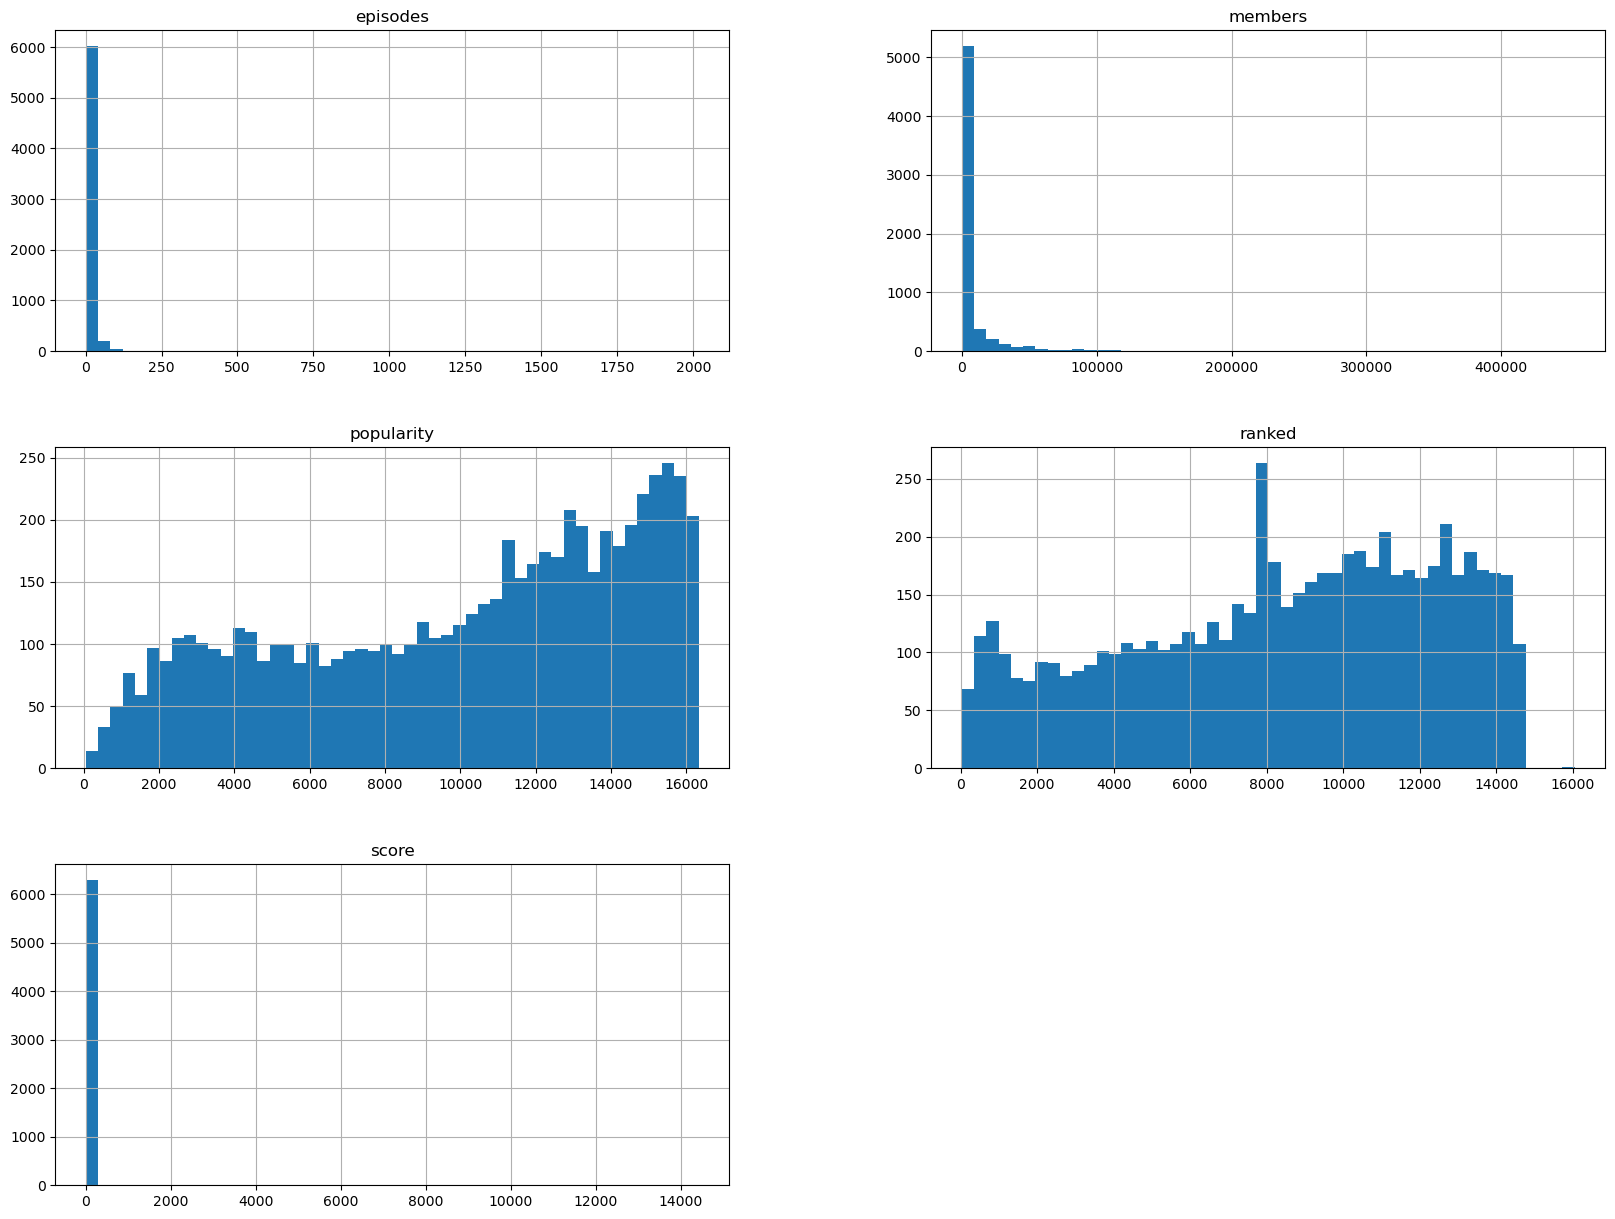

In [21]:
# Perform basic statistical analysis
df.describe().show()

# Convert Spark DataFrame to Pandas DataFrame for plotting
pdf = df.toPandas()

# Plot histograms for numerical columns
pdf.hist(bins=50, figsize=(20, 15))
plt.show()

#### Correlation Matrix

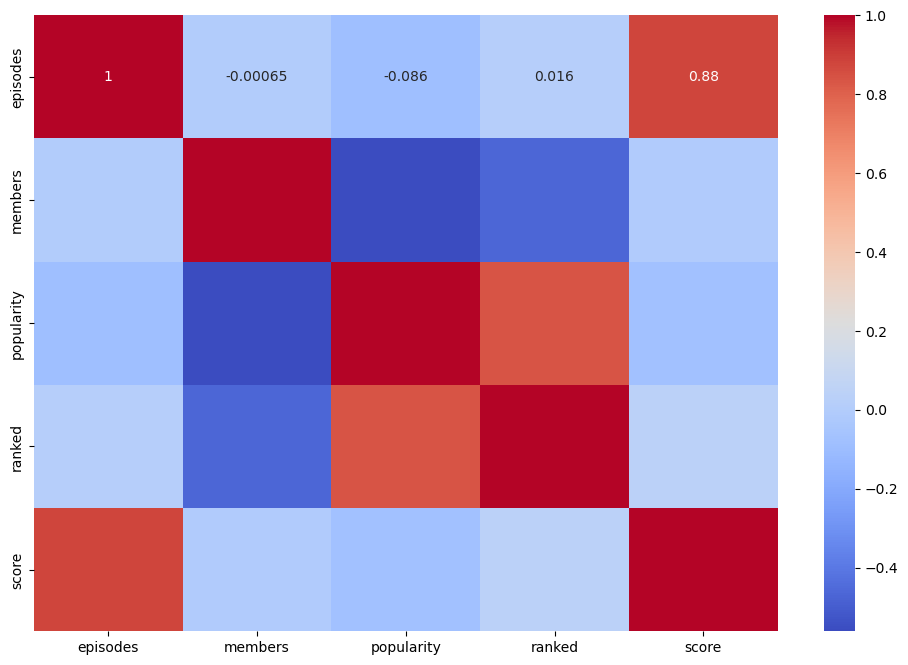

In [22]:
# Select only the numeric columns for correlation calculation
numeric_cols = pdf.select_dtypes(include=['float', 'int']).columns

# Calculate the correlation matrix using only numeric columns
corr_matrix = pdf[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Random Forest Regression

In [23]:
# Define the feature columns
feature_columns = ["episodes", "members", "popularity", "ranked"]

# Assemble the feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

In [24]:
# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Select the features and target column
data = df_scaled.select("scaledFeatures", "score")

In [25]:
# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [26]:
# Create a Random Forest Regressor model
rf = RandomForestRegressor(labelCol="score", featuresCol="scaledFeatures")

In [27]:
# Fit the model on the training data
rf_model = rf.fit(train_data)

In [28]:
# Get the feature importance
feature_importance = pd.DataFrame(
    {"feature": feature_columns, "importance": rf_model.featureImportances.toArray()}
).sort_values(by="importance", ascending=False)

print("Feature Importance:")
print(feature_importance)


Feature Importance:
      feature  importance
1     members    0.383293
0    episodes    0.231272
3      ranked    0.215587
2  popularity    0.169848


#### Feature Importance

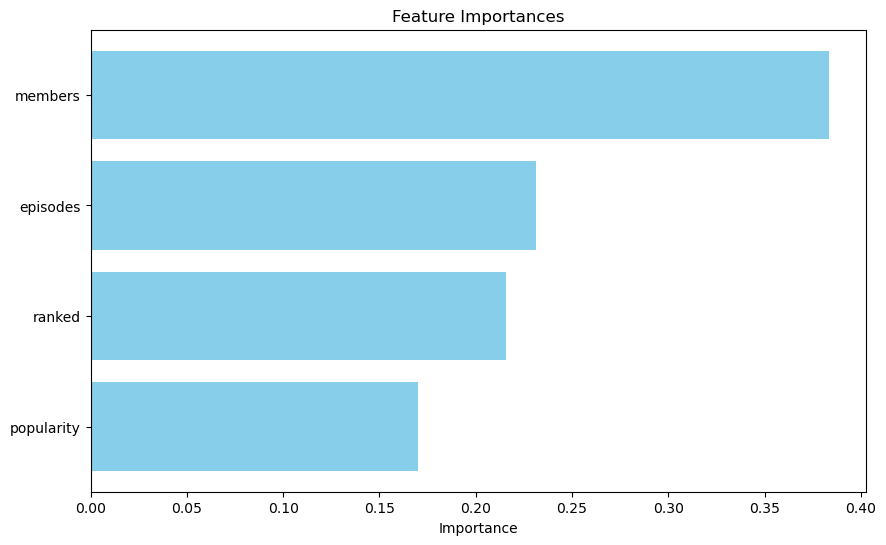

In [29]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"], feature_importance["importance"], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [30]:
# Evaluate the model on the test data
predictions = rf_model.transform(test_data)

# Debugging step: Verify the columns in the predictions DataFrame
print(predictions.columns)

# Debugging step: Show the first few rows of the predictions DataFrame
predictions.show(5)

['scaledFeatures', 'score', 'prediction']
+--------------------+-----+------------------+
|      scaledFeatures|score|        prediction|
+--------------------+-----+------------------+
|[0.01223115105792...|  6.1| 6.070330094319445|
|[0.01223115105792...| 5.63|  5.47594734536151|
|[0.01223115105792...| 5.81|5.7483386854229135|
|[0.01223115105792...| 5.77|5.7483386854229135|
|[0.01223115105792...|  5.7|  5.47594734536151|
+--------------------+-----+------------------+
only showing top 5 rows



In [41]:
# Calculate confusion matrix and accuracy
# Create a confusion matrix
predictions.groupBy('score', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label != prediction').count()
FP = predictions.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print("Accuracy of Decision Tree:", accuracy)



+-----+------------------+-----+
|score|        prediction|count|
+-----+------------------+-----+
| 6.04|6.0819586351451544|    1|
| 6.05| 6.129761698992267|    2|
| 5.85| 5.789097330786465|    3|
| 8.15| 7.621458133576906|    1|
|  5.9| 5.979385589326307|    1|
|  7.7| 7.735612387185705|    1|
| 5.82| 5.751513335885659|    1|
| 7.07| 6.942795913961294|    1|
| 5.92| 5.966235767825838|    1|
| 7.17| 7.055400026212555|    1|
| 7.83|  7.78789043664739|    1|
| 6.96| 6.942795913961294|    1|
| 6.11| 6.070330094319445|    2|
| 5.77| 5.925681637193842|    1|
| 7.11| 7.041020154762473|    1|
| 7.73| 7.758224649616059|    1|
| 5.73|  5.47594734536151|    1|
| 5.62|  5.44857666309873|    2|
| 5.79| 5.791569543831711|    2|
| 6.95| 6.999304871811317|    1|
+-----+------------------+-----+
only showing top 20 rows



AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `label` cannot be resolved. Did you mean one of the following? [`score`, `prediction`, `scaledFeatures`].; line 1 pos 19;
'Filter ((prediction#6425 = cast(0 as double)) AND ('label = prediction#6425))
+- Project [scaledFeatures#6378, score#5252, UDF(scaledFeatures#6378) AS prediction#6425]
   +- Sample 0.6, 1.0, false, 42
      +- Sort [scaledFeatures#6378 ASC NULLS FIRST, score#5252 ASC NULLS FIRST], false
         +- Project [scaledFeatures#6378, score#5252]
            +- Project [uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, episodes#5208, members#5219, popularity#5230, ranked#5241, score#5252, features#6323, UDF(features#6323) AS scaledFeatures#6378]
               +- Project [uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, episodes#5208, members#5219, popularity#5230, ranked#5241, score#5252, UDF(struct(episodes_double_VectorAssembler_46bcf5606e77, cast(episodes#5208 as double), members_double_VectorAssembler_46bcf5606e77, cast(members#5219 as double), popularity_double_VectorAssembler_46bcf5606e77, cast(popularity#5230 as double), ranked_double_VectorAssembler_46bcf5606e77, cast(ranked#5241 as double))) AS features#6323]
                  +- Filter atleastnnonnulls(10, uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, episodes#5208, members#5219, popularity#5230, ranked#5241, score#5252)
                     +- Project [uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, episodes#5208, members#5219, popularity#5230, ranked#5241, cast(score#5182 as float) AS score#5252]
                        +- Project [uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, episodes#5208, members#5219, popularity#5230, cast(ranked#5181 as int) AS ranked#5241, score#5182]
                           +- Project [uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, episodes#5208, members#5219, cast(popularity#5180 as int) AS popularity#5230, ranked#5181, score#5182]
                              +- Project [uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, episodes#5208, cast(members#5179 as int) AS members#5219, popularity#5180, ranked#5181, score#5182]
                                 +- Project [uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, cast(episodes#5178 as int) AS episodes#5208, members#5179, popularity#5180, ranked#5181, score#5182]
                                    +- Project [uid#5173, title#5174, synopsis#5175, genre#5176, aired#5177, episodes#5178, members#5179, popularity#5180, ranked#5181, score#5182]
                                       +- Relation [uid#5173,title#5174,synopsis#5175,genre#5176,aired#5177,episodes#5178,members#5179,popularity#5180,ranked#5181,score#5182,img_url#5183,link#5184] csv


In [31]:
# Convert predictions to Pandas DataFrame for plotting
predictions_df = predictions.toPandas()

# Debugging step: Check the unique values in 'score' and 'prediction' columns
print(predictions_df['score'].unique())
print(predictions_df['prediction'].unique())

[6.1000e+00 5.6300e+00 5.8100e+00 5.7700e+00 5.7000e+00 5.6000e+00
 5.7900e+00 5.8300e+00 5.6600e+00 5.9100e+00 5.7400e+00 6.0000e+00
 6.1300e+00 5.8000e+00 5.7800e+00 5.6200e+00 5.9800e+00 5.8700e+00
 5.5900e+00 5.6500e+00 5.9000e+00 5.6900e+00 6.0300e+00 5.6400e+00
 5.8400e+00 5.7500e+00 6.1100e+00 5.6100e+00 5.7300e+00 5.8200e+00
 5.7600e+00 5.7100e+00 5.6700e+00 5.9300e+00 5.7200e+00 5.8500e+00
 5.5800e+00 6.1500e+00 6.0800e+00 5.9600e+00 6.0400e+00 5.8800e+00
 6.0700e+00 5.9500e+00 8.2400e+00 5.9900e+00 8.0100e+00 5.8900e+00
 7.1300e+00 8.1500e+00 6.0200e+00 6.1200e+00 5.9200e+00 6.0900e+00
 7.0600e+00 6.0600e+00 6.0500e+00 5.8600e+00 7.0500e+00 6.0100e+00
 6.9700e+00 6.1400e+00 8.0300e+00 7.1200e+00 7.0400e+00 5.6800e+00
 7.0900e+00 7.0200e+00 6.9600e+00 7.0700e+00 7.1400e+00 7.1600e+00
 5.9400e+00 6.9500e+00 7.1700e+00 7.0800e+00 7.0300e+00 7.0100e+00
 7.7100e+00 7.8500e+00 8.1300e+00 7.5700e+00 7.8700e+00 8.2500e+00
 7.7700e+00 7.1000e+00 7.0000e+00 7.8400e+00 6.9400e+00 8.3400

In [32]:
# Calculate the evaluation metrics
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")
# Calculate and print prediction accuracy
accuracy = predictions_df.apply(lambda row: 1 if abs(row["score"] - row["prediction"]) <= 1 else 0, axis=1).mean()
print(f"Prediction Accuracy: {accuracy}")

RMSE: 121.7143071182246
R2: 0.9434065813667313
Prediction Accuracy: 0.8954802259887006


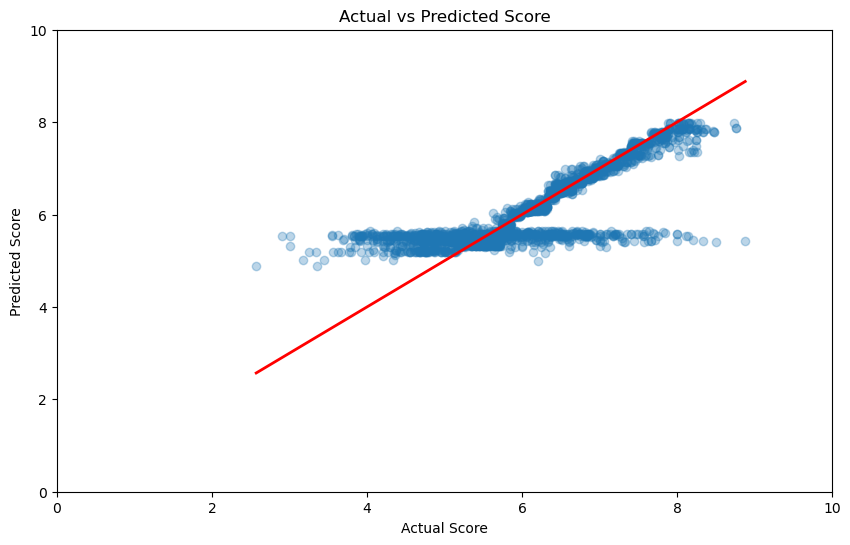

In [33]:
# Filter out extreme values (optional, depending on the data)
predictions_df = predictions_df[(predictions_df["prediction"] >= 0) & (predictions_df["prediction"] <= 10)]

# Plot the predicted vs actual scores
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df["score"], predictions_df["prediction"], alpha=0.3)
plt.plot([predictions_df["score"].min(), predictions_df["score"].max()],
         [predictions_df["score"].min(), predictions_df["score"].max()],
         color='red', lw=2)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Score")
plt.show()